In [1]:
import napari 

from dataset import (
    BlastoDataset,
    show_random_dataset_image,
    show_random_dataset_napari
)

In [2]:
dataset = BlastoDataset("blastocyst_training")

the mean intensity is [[100.47372881 100.54322034 100.29237288 ... 101.44491525 100.63983051
   99.93050847]
 [ 99.71949153 100.92711864 100.25254237 ... 100.7559322  100.46610169
   99.81694915]
 [ 99.5        100.21525424  99.97627119 ... 100.59152542 100.81101695
   99.8720339 ]
 ...
 [100.40423729 100.94915254 100.31949153 ... 101.19915254 100.68728814
  100.27711864]
 [100.38220339 100.94661017 100.27457627 ... 100.76440678 100.78813559
   99.88898305]
 [ 99.75084746 100.86101695 100.25677966 ... 100.56440678 100.58050847
   99.9220339 ]] the std is [[5.26405991 5.6727714  4.3916457  ... 5.29289734 4.16217104 3.75796349]
 [5.76063142 5.60067582 4.76771828 ... 5.67851351 4.5407425  4.33555081]
 [4.72829564 4.30286911 3.42118718 ... 4.15495572 3.66717653 3.2167039 ]
 ...
 [5.76239848 4.80209604 4.01718255 ... 6.33461028 4.04923191 3.93769078]
 [4.59795701 4.89877505 3.37350561 ... 4.2392941  3.3591557  3.15563214]
 [3.7544041  3.76662493 2.93794517 ... 3.21886719 3.05311062 2.765530

/localscratch/miniforge3/envs/segmentation/lib/python3.10/site-packages/torchvision/transforms/_functional_tensor.py:918: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987280714/work/torch/csrc/utils/tensor_new.cpp:275.)
  mean = torch.as_tensor(mean, dtype=dtype, device=tensor.device)


In [3]:
print(dataset)
print(dataset.__getitem__(4))

(tensor([[[-19.0160, -17.6478, -22.7496,  ..., -19.0877, -24.0864, -26.4915],
         [-17.2431, -17.9449, -20.9443,  ..., -17.6791, -22.0434, -22.9324],
         [-20.9564, -23.1983, -29.1081,  ..., -24.1137, -27.3853, -30.9236],
         ...,
         [-17.3539, -20.9361, -24.8769,  ..., -15.9155, -24.7651, -25.3684],
         [-21.7483, -20.5312, -29.6091,  ..., -23.6702, -29.8861, -31.5336],
         [-26.4625, -26.6745, -33.9913,  ..., -31.1191, -32.8177, -35.9937]]]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int16))


Image size is {torch.Size([256, 256])}


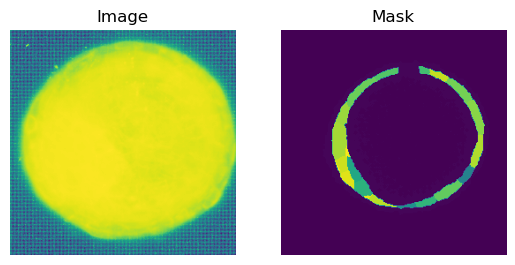

In [4]:
show_random_dataset_image(dataset)

In [5]:
img, mask = dataset[8]

In [6]:
dataset.__len__()

1180

In [7]:
viewer  = napari.Viewer()

In [8]:
show_random_dataset_napari(dataset, viewer)